Modules

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

C:\Users\Public\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Definition of RNN

In [2]:
"""
References:
1. Class notes: IIT Delhi: ell884 : Deep Learning for NLP
2. https://d2l.ai/chapter_recurrent-neural-networks/index.html
3. https://gist.github.com/karpathy/d4dee566867f8291f086
"""
class RNN:
    
    """
    1. 'x_train' is a [preprocessed] DataFrame
    2. 'hidden_neurons' = size of the hidden-layer
    - This RNN has a single hidden-layer
    """
    def __init__(self, x_train, hidden_neurons= 32):

        # Converts the DataFrame to a NumPy-matrix
        x = x_train.to_numpy(dtype= np.float32)
        
        # Adjust dimensions to prevent error during forward-pass (upon calculation of 'z')
        self.x = np.reshape(x, (x.shape[0], x.shape[1], 1))

        # Save dimension of the input
        self.D = self.x.shape[1]

        # Creates the RNN
        self.size = hidden_neurons
        self.build_nn(size= self.size)

    """
    1. This functions creates the Matrices which comprise the NN
    2. Initializes the variables with a variant of Xavier's method
    - Instead of 'sqrt(n)'', I used 'n'
    - This initialization increases the correlation-coefficients
    - Reference: https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
    
    """
    def build_nn(self, size):
        
        k = 2**(int(np.ceil(np.log2(self.D)))) # Sets k := power-of-2 near self.D
        h = 1/k # (l, h) = the range of a uniform-distibution
        l = -h
        
        # This is the Recurrent-neural-network
        self.Wxh = np.random.uniform(low=l, high=h, size=(size, self.D))
        self.Whh = np.random.uniform(low=l, high=h, size=(size, size))
        self.Why = np.random.uniform(low=l, high=h, size=(self.D, size))
        self.bh  = np.random.uniform(low=l, high=h, size=(size, 1))
        self.by  = np.random.uniform(low=l, high=h, size=(self.D, 1))
        

    """
    Performs,
    1. a forward-pass on the mini-batch of (data, target) = (x, y)
    2. a backward-pass to calculate the Gradients
    Here, hprev = the initial hidden-state
    """
    def compute(self, x, y, hprev):

        #1. FORWARD PASS: To generate predictions
        
        # These hash-tables store the (input, hidden-state, output) at each time-step
        xs, hs, ys = {}, {}, {}
        hs[-1] = np.copy(hprev)

        loss = 0
        for t in range(len(x)):
            # input
            xs[t] = x[t]
            # hidden-state
            z = np.dot(self.Wxh, xs[t]) + np.dot(self.Whh, hs[t-1]) + self.bh
            hs[t] = np.tanh(z)
            # output
            ys[t] = np.dot(self.Why, hs[t]) + self.by
            # loss
            d = ys[t] - y[t]
            loss += np.dot(d[0], d[0]) #SSE

        loss = (loss) / (2*len(x)) #MSE
        
        #2. BACKWARD PASS: To compute the gradients
        
        # These variables shall store the gradients
        # Notation: dvar := Gradient of the 'Loss_function' w.r.t. the variable 'var'
        self.dWxh, self.dWhh, self.dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        self.dbh, self.dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(hs[0])
        
        for t in reversed(range(len(x))):
            dy = ys[t] - y[t]
            
            self.dby += dy
            self.dWhy += np.dot(dy, hs[t].T)
            
            dh = np.dot(self.Why.T, dy) + dhnext
            dz = np.multiply(1 - np.square(hs[t]), dh)
            
            self.dbh += dz
            self.dWxh += np.dot(dz, xs[t].T)
            self.dWhh += np.dot(dz, hs[t-1].T)
            
            dhnext = np.dot(self.Whh.T, dz)

        # Performs Gradient-clipping
        for grad in [self.dWxh, self.dWhh, self.dWhy, self.dbh, self.dby]:
            np.clip(grad, -10, 10, out= grad)

        return loss, (self.dWxh, self.dWhh, self.dbh), (self.dWhy, self.dby), hs[len(x)-1] # hs[len(X)-1] == the last hidden-state

    
    """
    1. This function is used to train the RNN
    2. To "truncate" BPTT, 'seq_length' is used to truncate the input-sequence
    - BPTT := Backpropagation-Through-Time
    """
    def train(self, epochs= 100, lr= 3e-4, seq_length= 18):
        
        # This variable is used later, when generating-predictions
        self.seq_length = seq_length

        # Initialization
        """
        RMSprop (Adaptive Gradient):
        These variables shall be used to vary the gradient (according to its magnitude) to ensure convergence
        """
        mWxh, mWhh, mWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        mbh, mby = np.zeros_like(self.bh), np.zeros_like(self.by)
        b  = 0.9 # beta
        a = 1 - b 

        # initial-hidden-state
        hprev = np.zeros((self.size, 1))

        # Training the NN
        i = 0 # This is used to parse the dataset
        for e in range(epochs):

            # If the whole-dataset has been parsed, then restart
            if i+seq_length >= len(self.x):
                hprev = np.zeros((self.size, 1))
                i = 0
            
            # Selects a mini-batch of input & target
            x = self.x[i:i+seq_length]
            y = self.x[i+1:i+1+seq_length]

            # Calculates the gradient for the mini-batch
            loss, (self.dWxh, self.dWhh, self.dbh), (self.dWhy, self.dby), hprev = self.compute(x, y, hprev)

            # Prints progress
            if e % 3600 == 0:
                print(f"Epoch {e} : Loss {round(loss, 4)} ---- ", end="")

            """
            p = parameter
            g = gradient
            m = m_t = [beta * m_{t-1}] + [(1-beta)*(np.square(g))]
            """
            for p, g, m in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by], [self.dWxh, self.dWhh, self.dWhy, self.dbh, self.dby], [mWxh, mWhh, mWhy, mbh, mby]):
                m = b*m + a*np.square(g)
                p += -lr*g / np.sqrt(m + 1e-6) #Adaptive Gradient

            i += seq_length
    
    """
    1. This function is used to test the trained-model on a validation-dataset
    2. I utilize "Teacher-forcing" during training and validation, to not-drift-away from the true-sequence
    """
    def validate(self, x_test):
        
        # Converts the Testing dataset to a NumPy-Array
        a = x_test.to_numpy(dtype= np.float32)
        a = np.reshape(a, (a.shape[0], a.shape[1], 1))
        
        x = a[:-1] # inputs
        y = a[1:] # targets
        
        pred = np.zeros_like(y) # stores predictions
        loss = 0
        hprev = None
        seq_length = self.seq_length
        
        for t in range(len(x)):
            
            # Resetting the hidden-state improves correlation b/w the actual & predicted values
            if t % seq_length == 0:
                hprev = np.zeros((self.size, 1))
            
            # hidden state    
            z = np.dot(self.Wxh, x[t]) + np.dot(self.Whh, hprev) + self.bh
            h = np.tanh(z)
            hprev = h
            # output
            pred[t] = np.dot(self.Why, h) + self.by
            #loss
            d = pred[t] - y[t]
            loss += np.dot(d[0], d[0]) #SSE
            
        loss = (loss) / (2*len(x)) #MSE
            
        return y, pred, loss
    
    


In [3]:
"""
Performs preprocessing on the dataset by
1. Dropping unncessary columns
2. Normalizing the dataset, which significantly affects the model's performance
"""
def read(path):
    df = pd.read_csv(path, header=0)
    
    # Drops the columns
    df.drop(['Close', 'Adj Close'], axis=1, inplace=True)
    
    # Converts the string under 'Date' to an object of the class 'datetime'
    df['Date'] = df['Date'].apply( func= lambda x: datetime.strptime(x, "%Y-%m-%d").date() )
    
    # sets year := 2021
    year = datetime(2021, 1, 1).date()

    # Separate the Data based on 'year'
    df1 = df[df['Date'] < year].drop(['Date'], axis= 1)
    df2 = df[df['Date'] >= year].drop(['Date'], axis= 1)
    
    # For pretty-printing
    dates = df[df['Date'] >= year]['Date']

    
    # Normalize the data
    scaler = StandardScaler()
    x_train = pd.DataFrame(scaler.fit_transform(df1), columns= df1.columns)
    # NOTE: It is necessary to normalize the validation-dataset separately. Else the model's performance is terrible
    x_test  = pd.DataFrame(scaler.fit_transform(df2), columns= df2.columns)
    
    return x_train, (x_test, dates, scaler)

In [4]:
# Read & Preprocess the data
x_train, (x_test, dates, scaler) = read('./GOOGL.csv')

In [5]:
# Creates an untrained RNN
rnn = RNN(x_train)

In [6]:
# Hyperparameters
epochs = 229*500
#lr= 3e-4,
#seq_length= 18 #to truncate Backpropagation-Through-Time

In [7]:
# Trains the model on stock-prices upto 2020
rnn.train(epochs= epochs)

Epoch 0 : Loss 0.379 ---- Epoch 3600 : Loss 0.0021 ---- Epoch 7200 : Loss 0.0001 ---- Epoch 10800 : Loss 0.0005 ---- Epoch 14400 : Loss 0.0003 ---- Epoch 18000 : Loss 0.0073 ---- Epoch 21600 : Loss 0.0015 ---- Epoch 25200 : Loss 0.0005 ---- Epoch 28800 : Loss 0.0003 ---- Epoch 32400 : Loss 0.0009 ---- Epoch 36000 : Loss 0.0008 ---- Epoch 39600 : Loss 0.0011 ---- Epoch 43200 : Loss 0.0003 ---- Epoch 46800 : Loss 0.0005 ---- Epoch 50400 : Loss 0.0034 ---- Epoch 54000 : Loss 0.001 ---- Epoch 57600 : Loss 0.0003 ---- Epoch 61200 : Loss 0.0016 ---- Epoch 64800 : Loss 0.0036 ---- Epoch 68400 : Loss 0.0187 ---- Epoch 72000 : Loss 0.0016 ---- Epoch 75600 : Loss 0.002 ---- Epoch 79200 : Loss 0.0009 ---- Epoch 82800 : Loss 0.0003 ---- Epoch 86400 : Loss 0.0248 ---- Epoch 90000 : Loss 0.0001 ---- Epoch 93600 : Loss 0.0001 ---- Epoch 97200 : Loss 0.001 ---- Epoch 100800 : Loss 0.0014 ---- Epoch 104400 : Loss 0.0005 ---- Epoch 108000 : Loss 0.001 ---- Epoch 111600 : Loss 0.0004 ---- 

In [8]:
# Generates predictions for 2021
y, pred, loss = rnn.validate(x_test)

In [9]:
y = np.reshape(y, (y.shape[0], y.shape[1]))
p = np.reshape(pred, (pred.shape[0], pred.shape[1]))

Visualizing the results

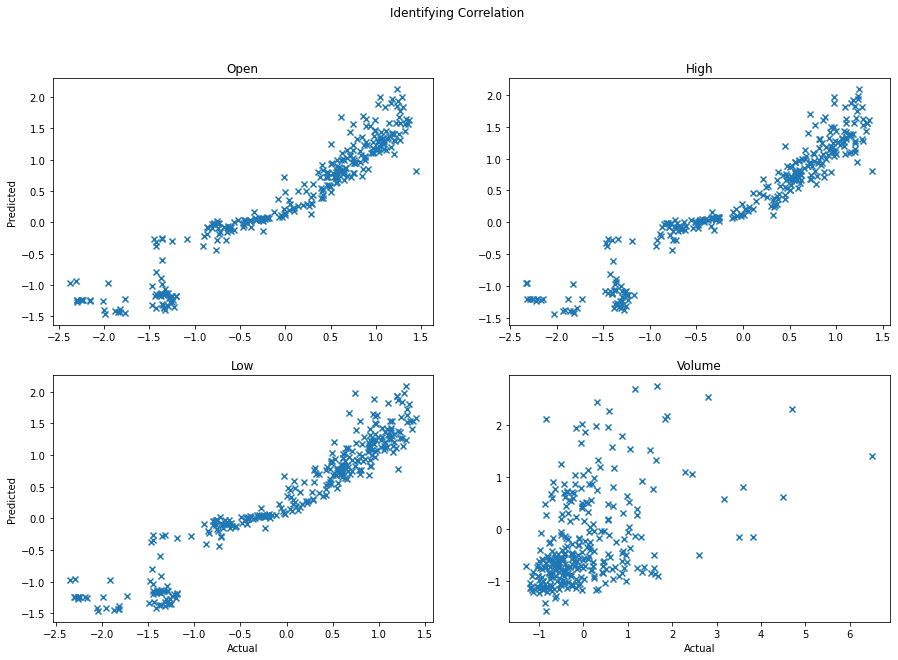

In [10]:
cols = x_test.columns
fig, axes = plt.subplots(nrows= 2, ncols= 2, figsize= (15, 10))

for d in range(4):
    axes[d//2, d%2].scatter(y[:, d], p[:, d],  marker= 'x')
    axes[d//2, d%2].set_title(cols[d])

axes[0, 0].set_ylabel("Predicted")    
axes[1, 0].set_ylabel("Predicted")
axes[1, 0].set_xlabel("Actual")
axes[1, 1].set_xlabel("Actual")

fig.suptitle("Identifying Correlation")
    
plt.show()

del fig, axes

In [11]:
# Correlation between the Actual & Predicted stock-prices
print("Correlation Coefficients:")
for d in range(4):
    r = np.corrcoef(y[:, d], p[:, d])[0, 1]
    print(f"{cols[d]} \t: {round(r, 3)}")

Correlation Coefficients:
Open 	: 0.957
High 	: 0.954
Low 	: 0.956
Volume 	: 0.449


In [12]:
# Denormalizes the predictions (to get gain useful information)
y = scaler.inverse_transform(y)
p = scaler.inverse_transform(p)

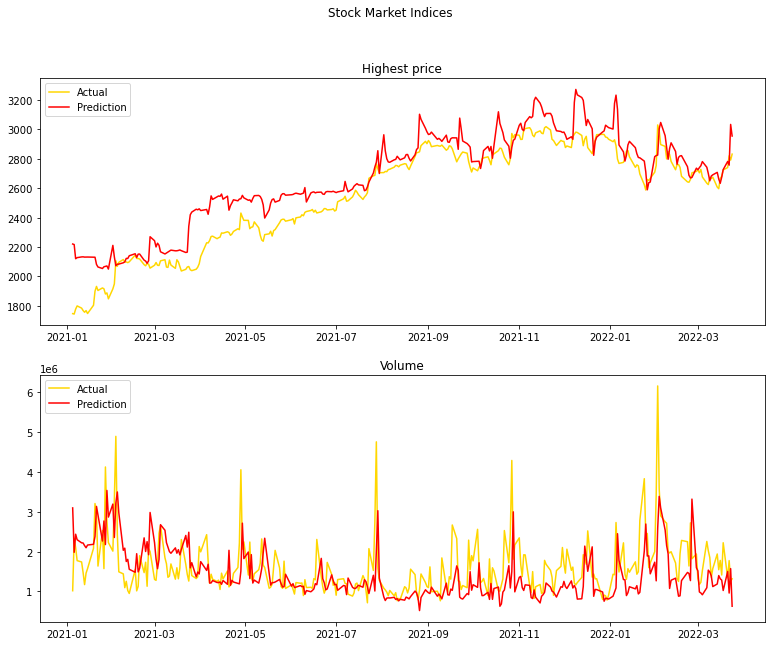

In [13]:
fig, axes = plt.subplots(nrows= 2, ncols= 1, figsize= (13, 10))

x = dates[1:]
axes[0].plot(x, y[:, 1], color= 'gold')
axes[0].plot(x, p[:, 1], color= 'red')

axes[1].plot(x, y[:, 3], color= 'gold')
axes[1].plot(x, p[:, 3], color= 'red')

# Pretty printing
fig.suptitle("Stock Market Indices")

axes[0].set_title("Highest price")
axes[0].legend(['Actual', 'Prediction'], loc= 'upper left')

axes[1].set_title("Volume")
axes[1].legend(['Actual', 'Prediction'], loc= 'upper left')


plt.show()

In [14]:
# MSE between the actual & predicted stock-prices (& volumes) for the year 2021 (& some months of 2022)
print("MSE:", round(loss, 5))

MSE: 0.10391
